# CRNPy example for a stationary detector

Authors: Joaquin Peraza and Andres Patrignani - 2024

Affiliation: Kansas State University

Contact: andrespatrignani@ksu.edu

In [ ]:
# Install the crnpy module
!pip install crnpy


In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import crnpy

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Define geographic coordiantes of site
lat = 39.110596
lon = -96.613050


### Load data

In [3]:
# Load observations from a stationary detector
filepath = "https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/stationary/rdt.csv"

# Read the DataFrame
col_names = ['timestamp','barometric_pressure_Avg','relative_humidity_Avg', 'air_temperature_Avg','DP','BattVolt','counts_1_Tot','counts_2_Tot','counts_3_Tot']
df = pd.read_csv(filepath, names=col_names, parse_dates=['timestamp'])

# Display a few rows of the dataset
df.head(3)

,timestamp,barometric_pressure_Avg,relative_humidity_Avg,air_temperature_Avg,DP,BattVolt,counts_1_Tot,counts_2_Tot,counts_3_Tot
0,2020-04-10 09:47:00,983.8,29.0,9.6,-7.4,14.4,848,716.0,742
1,2020-04-10 10:47:00,982.3,25.0,10.9,-7.9,14.3,436,7200.0,796
2,2020-04-10 11:17:00,980.8,25.0,11.5,-7.4,13.7,389,396.0,354


### Find cutoff rigidity and reference neutron monitor

In [ ]:
# Define study start and end dates
start_date = df.iloc[0]['timestamp']
end_date = df.iloc[-1]['timestamp']

# Find approximate cutoff rigidity for this location
cutoff = crnpy.cutoff_rigidity(lat, lon)

# Find stations with cutoff rigidity similar to estimated by lat,lon
crnpy.find_neutron_monitor(cutoff, start_date=start_date, end_date=end_date, verbose=False)

In [12]:
# Download incoming neutron flux data from the Neutron Monitor Database (NMDB).
nmdb = crnpy.get_incoming_neutron_flux(start_date, end_date, station="IRKT", utc_offset=-6)
nmdb.head(3)


,timestamp,counts
0,2020-04-10 12:00:00,184.417
1,2020-04-10 13:00:00,185.700
2,2020-04-10 14:00:00,185.333


### Find outliers, fill timestamps, and replace missing values

In [6]:
# Remove rows with incomplete intervals
df = crnpy.remove_incomplete_intervals(df, timestamp_col='timestamp', integration_time=3600, remove_first=True)

# Fill missing timestamps to create a conplete record
df = crnpy.fill_missing_timestamps(df, timestamp_col='timestamp', freq='h', round_timestamp=True)

# Flag and fill outliers
cols_counts = ['counts_1_Tot','counts_2_Tot','counts_3_Tot']
for col in cols_counts:
    
    # Find outliers
    idx_outliers = crnpy.is_outlier(df[col], method='scaled_mad', min_val=500, max_val=2000)
    df.loc[idx_outliers,col] = np.nan
    
    # Fill missing values with linear interpolation and round to nearest integer
    df[col] = df[col].interpolate(method='linear', limit=3, limit_direction='both').round()

# Compute total cunts
df['total_raw_counts'] = crnpy.total_raw_counts(df[cols_counts])

Removed a total of 14 rows.
Added a total of 0 missing timestamps.


### Correct raw neutron counts

In [15]:
# Interpolate incoming neutron flux to match the timestamps in our station data
df['incoming_flux'] = crnpy.interpolate_incoming_flux(nmdb['timestamp'], nmdb['counts'], df['timestamp'])


In [16]:
# Compute correction factor for incoming neutron flux
df['fi'] = crnpy.correction_incoming_flux(incoming_neutrons=df['incoming_flux'],
                                          incoming_Ref=df['incoming_flux'].iloc[0])


In [17]:
# Fill NaN values in atmospheric data and neutron counts
df[['barometric_pressure_Avg','relative_humidity_Avg', 'air_temperature_Avg']] = df[['barometric_pressure_Avg','relative_humidity_Avg', 'air_temperature_Avg']].interpolate(method='pchip', limit=24, limit_direction='both')

# Compute the pressure correction factor 
df['fp'] = crnpy.correction_pressure(pressure=df['barometric_pressure_Avg'], Pref=df['barometric_pressure_Avg'].mean(), L=130)

# Calculate the absolute humidity (g cm^-3) and the vapor pressure correction factor
df['abs_humidity'] = crnpy.abs_humidity(df['relative_humidity_Avg'], df['air_temperature_Avg'])
df['fw'] = crnpy.correction_humidity(abs_humidity=df['abs_humidity'], Aref=0)


In [18]:
# Apply correction factors
df['total_corrected_neutrons'] = df['total_raw_counts'] * df['fw'] / (df['fp'] * df['fi'])


### Estimate volumetric water content and its uncertainty

In [19]:
# Device N0 parameter
N0_rdt = 3767 # Patrignani, et al. (2021). https://doi.org/10.3389/frwa.2021.673185

# Estimate lattice water (%) based on texture
lattice_water = crnpy.lattice_water(clay_content=0.35)

df['VWC'] = crnpy.counts_to_vwc(df['total_corrected_neutrons'], N0=N0_rdt, bulk_density=1.33, Wlat=lattice_water, Wsoc=0.01)

# Drop any NaN beofre smoothing
df = df.dropna(subset=['VWC']).copy().reset_index()

# Filter using the Savitzky-Golay filter, drop NaN values and timestamps
df['VWC'] = crnpy.smooth_1d(df['VWC'], window=11, order=3, method="savitzky_golay")


In [22]:
# Estimate the uncertainty of the volumetric water content
df['sigma_VWC'] = crnpy.uncertainty_vwc(df['total_raw_counts'], N0=N0_rdt, bulk_density=1.33, fp=df['fp'], fi=df['fi'], fw=df['fw'])


### Estimate sensing depth and rootzone soil moisture

In [20]:
# Estimate sensing depth
df['sensing_depth'] = crnpy.sensing_depth(df['VWC'], df['barometric_pressure_Avg'], df['barometric_pressure_Avg'].mean(), bulk_density=1.33, Wlat=lattice_water, method = "Franz_2012")
print(df['sensing_depth'].mean())

15.240990934932116


In [21]:
# Compute the storage using the exponential filter
vwc_surface = df['VWC']
vwc_subsurface = crnpy.exp_filter(df['VWC'])

z_surface = 150 # Average depth in mm obtained from previous cell
z_subsurface = 500 # Arbitrary subsurface depth in mm
df['storage'] = np.sum([vwc_surface*z_surface, vwc_subsurface*z_subsurface], axis=0)


### Create publication quality figure

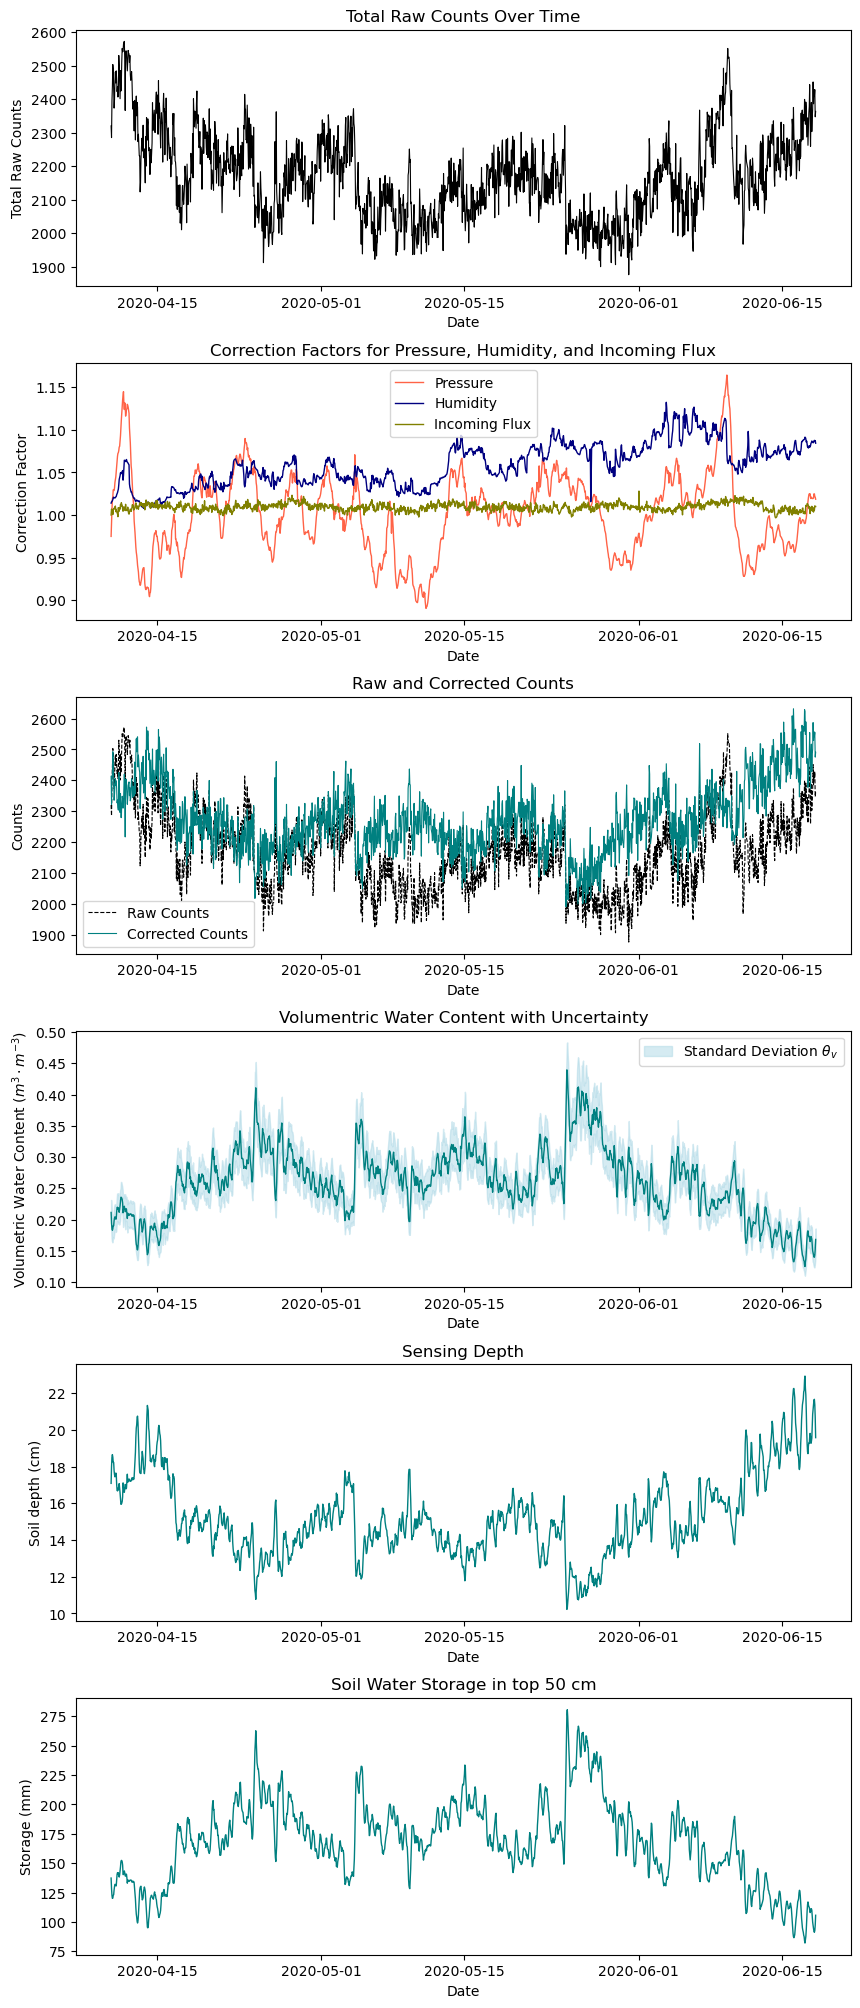

In [24]:
# Create a new figure
plt.figure(figsize=(10, 25))

plt.subplot(6,1,1)
plt.title('Total Raw Counts Over Time')
plt.plot(df['timestamp'], df['total_raw_counts'], label='Raw Counts', color='black', linewidth=.8)
plt.xlabel("Date")
plt.ylabel("Total Raw Counts")
plt.tick_params(axis='both', which='major')

plt.subplot(6,1,2)
plt.title('Correction Factors for Pressure, Humidity, and Incoming Flux')
plt.plot(df['timestamp'], df['fp'], label='Pressure',color='tomato', linewidth=1)
plt.plot(df['timestamp'], df['fw'], label='Humidity', color='navy', linewidth=1)
plt.plot(df['timestamp'], df['fi'], label='Incoming Flux', color='olive', linewidth=1)
plt.xlabel("Date")
plt.ylabel('Correction Factor')
plt.legend()

plt.subplot(6,1,3)
plt.title('Raw and Corrected Counts')
plt.plot(df['timestamp'], df['total_raw_counts'], label='Raw Counts', color='black', linestyle='dashed', linewidth=.8)
plt.plot(df['timestamp'], df['total_corrected_neutrons'], label='Corrected Counts', color='teal', linewidth=.8)
plt.xlabel("Date")
plt.ylabel('Counts')
plt.legend()

plt.subplot(6,1,4)
plt.title('Volumentric Water Content with Uncertainty')
plt.plot(df['timestamp'], df['VWC'], color='teal', linewidth=1.0)
plt.fill_between(df['timestamp'], df['VWC']-df['sigma_VWC'], df['VWC']+df['sigma_VWC'], color='lightblue', alpha=0.5, label = r"Standard Deviation $\theta_v$")
plt.xlabel("Date")
plt.ylabel(r"Volumetric Water Content ($m^3 \cdot m^{-3}$)")
plt.legend()

plt.subplot(6,1,5)
plt.title('Sensing Depth')
plt.plot(df['timestamp'], df['sensing_depth'] , color='teal', linewidth=1.0)
plt.xlabel("Date")
plt.ylabel("Soil depth (cm)")

plt.subplot(6,1,6)
plt.title('Soil Water Storage in top 50 cm')
plt.plot(df['timestamp'], df['storage'], color='teal', linewidth=1.0)
plt.xlabel("Date")
plt.ylabel("Storage (mm)")

plt.subplots_adjust(hspace=0.3)

#plt.savefig('stationary_crnpy.jpg', dpi=300)
plt.show()